In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import gc
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df = pd.DataFrame(data)

output_csv = "dataset.csv"
df.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")


CSV file saved as dataset.csv


In [4]:
df.head()

,image_path,category
0,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
1,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
2,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
3,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
4,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented


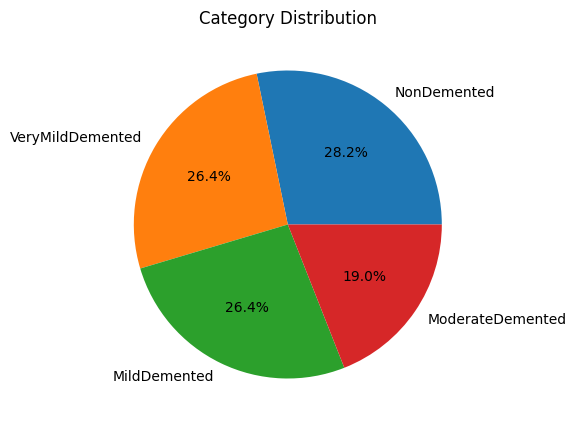

In [5]:
category_counts = df["category"].value_counts()

plt.figure(figsize=(12, 5))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%")
plt.title("Category Distribution")
plt.show()

In [6]:
def show_random_images(column, number_of_images_to_show=5, grey=False):
    categories = df["category"].unique()
    
    images_per_category = number_of_images_to_show
    
    plt.figure(figsize=(15, len(categories) * 5))
    for i, category in enumerate(categories):
        category_images = df[df["category"] == category][column].tolist()
        
        for j in range(min(len(category_images), images_per_category)):
            img_data = category_images[j]
            if column != "image_path":
                img = img_data
            else:
                img = cv2.imread(img_data)
                
            if column == "image_path":
                if grey:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(len(categories), images_per_category, i * images_per_category + j + 1)
            
            if grey:
                plt.imshow(img, cmap="gray")
            else:
                plt.imshow(img)
            
            plt.axis("off")
            plt.title(f"{category}")
    
    plt.tight_layout()
    plt.show()

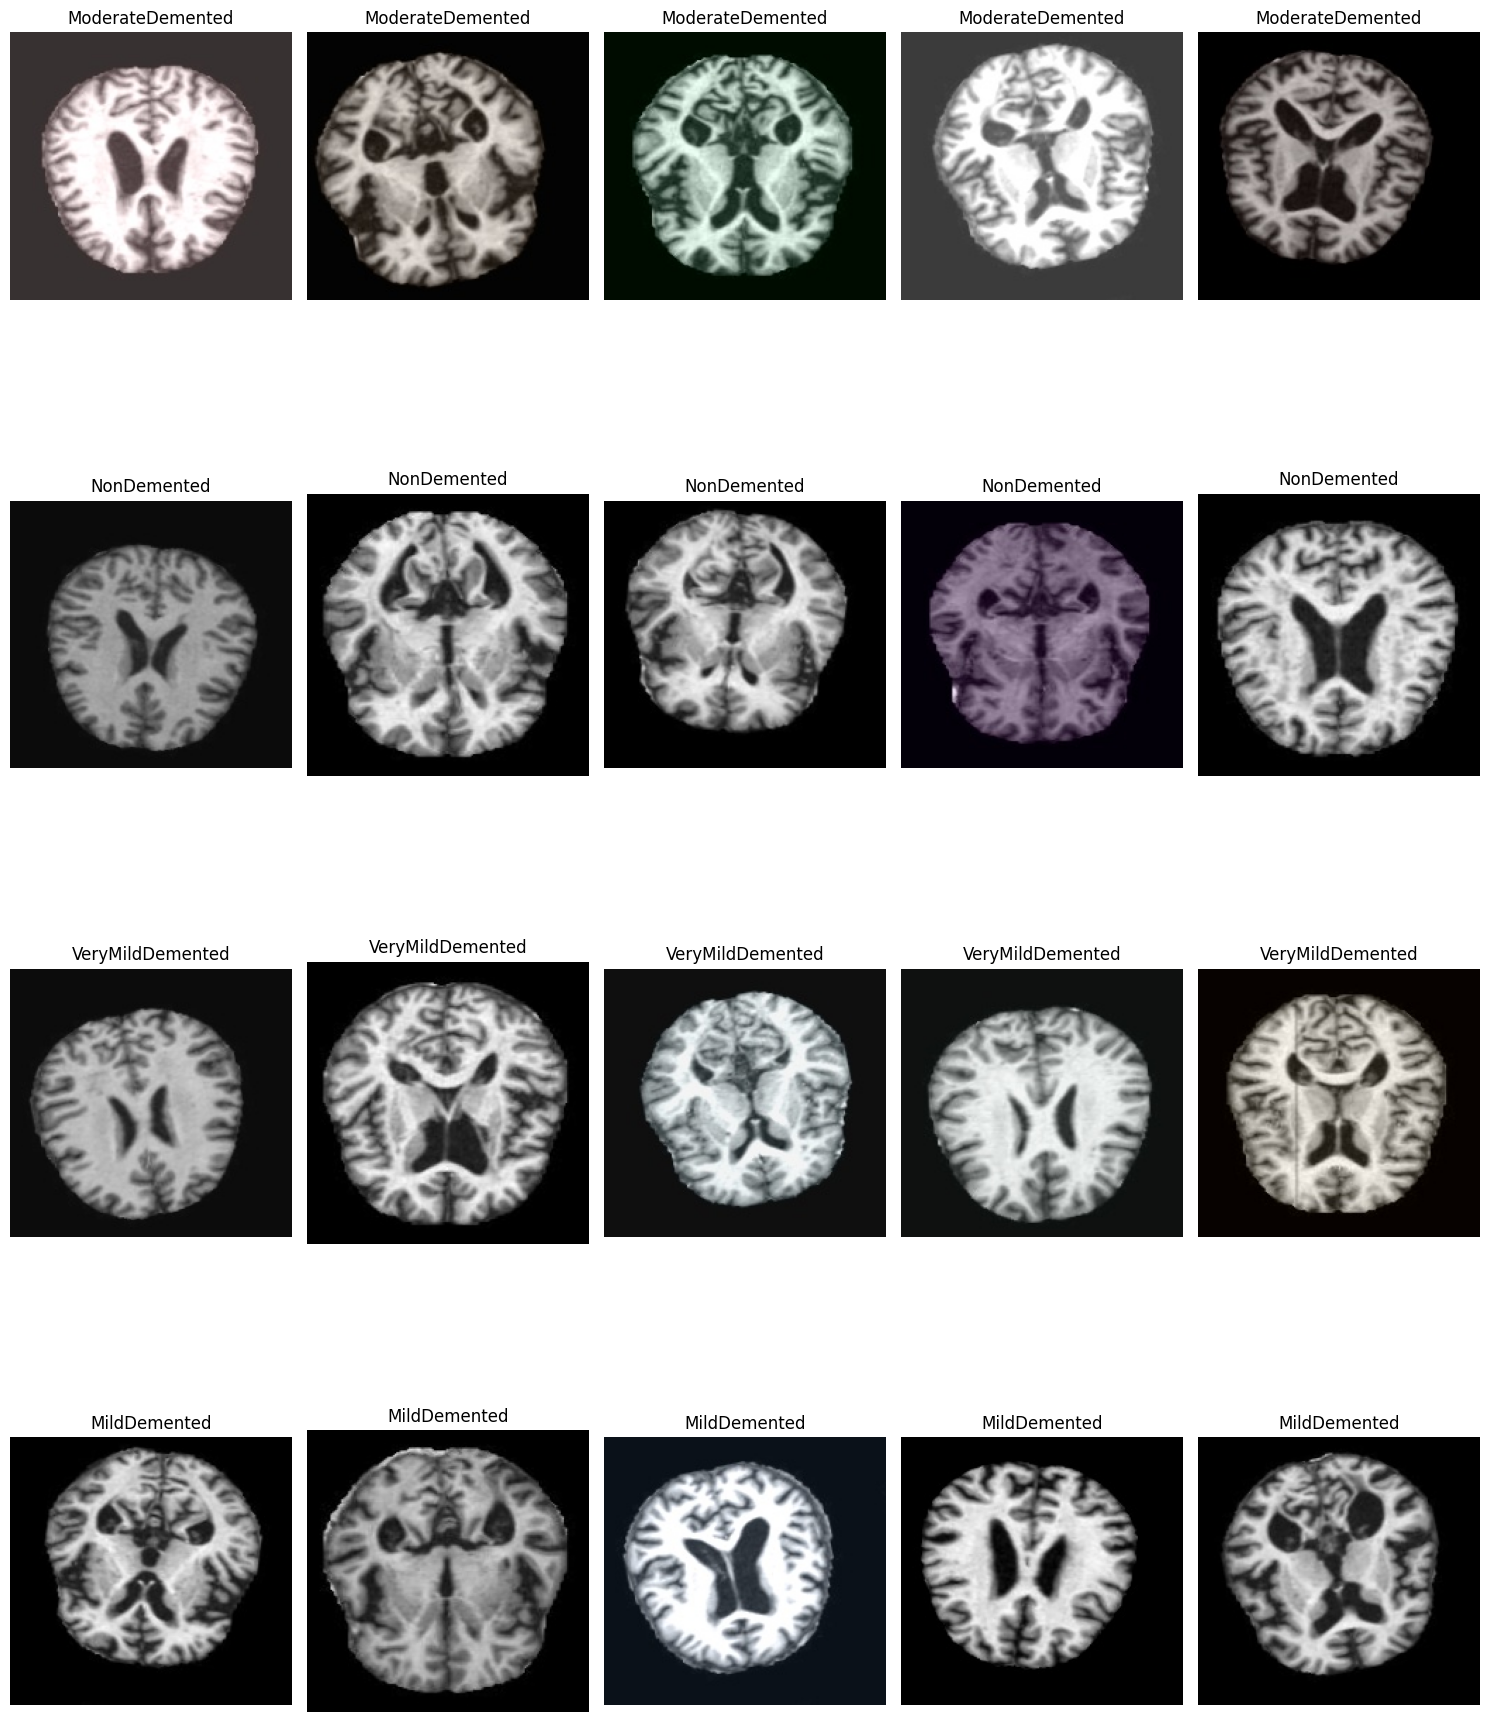

In [7]:
show_random_images("image_path", 5, False)

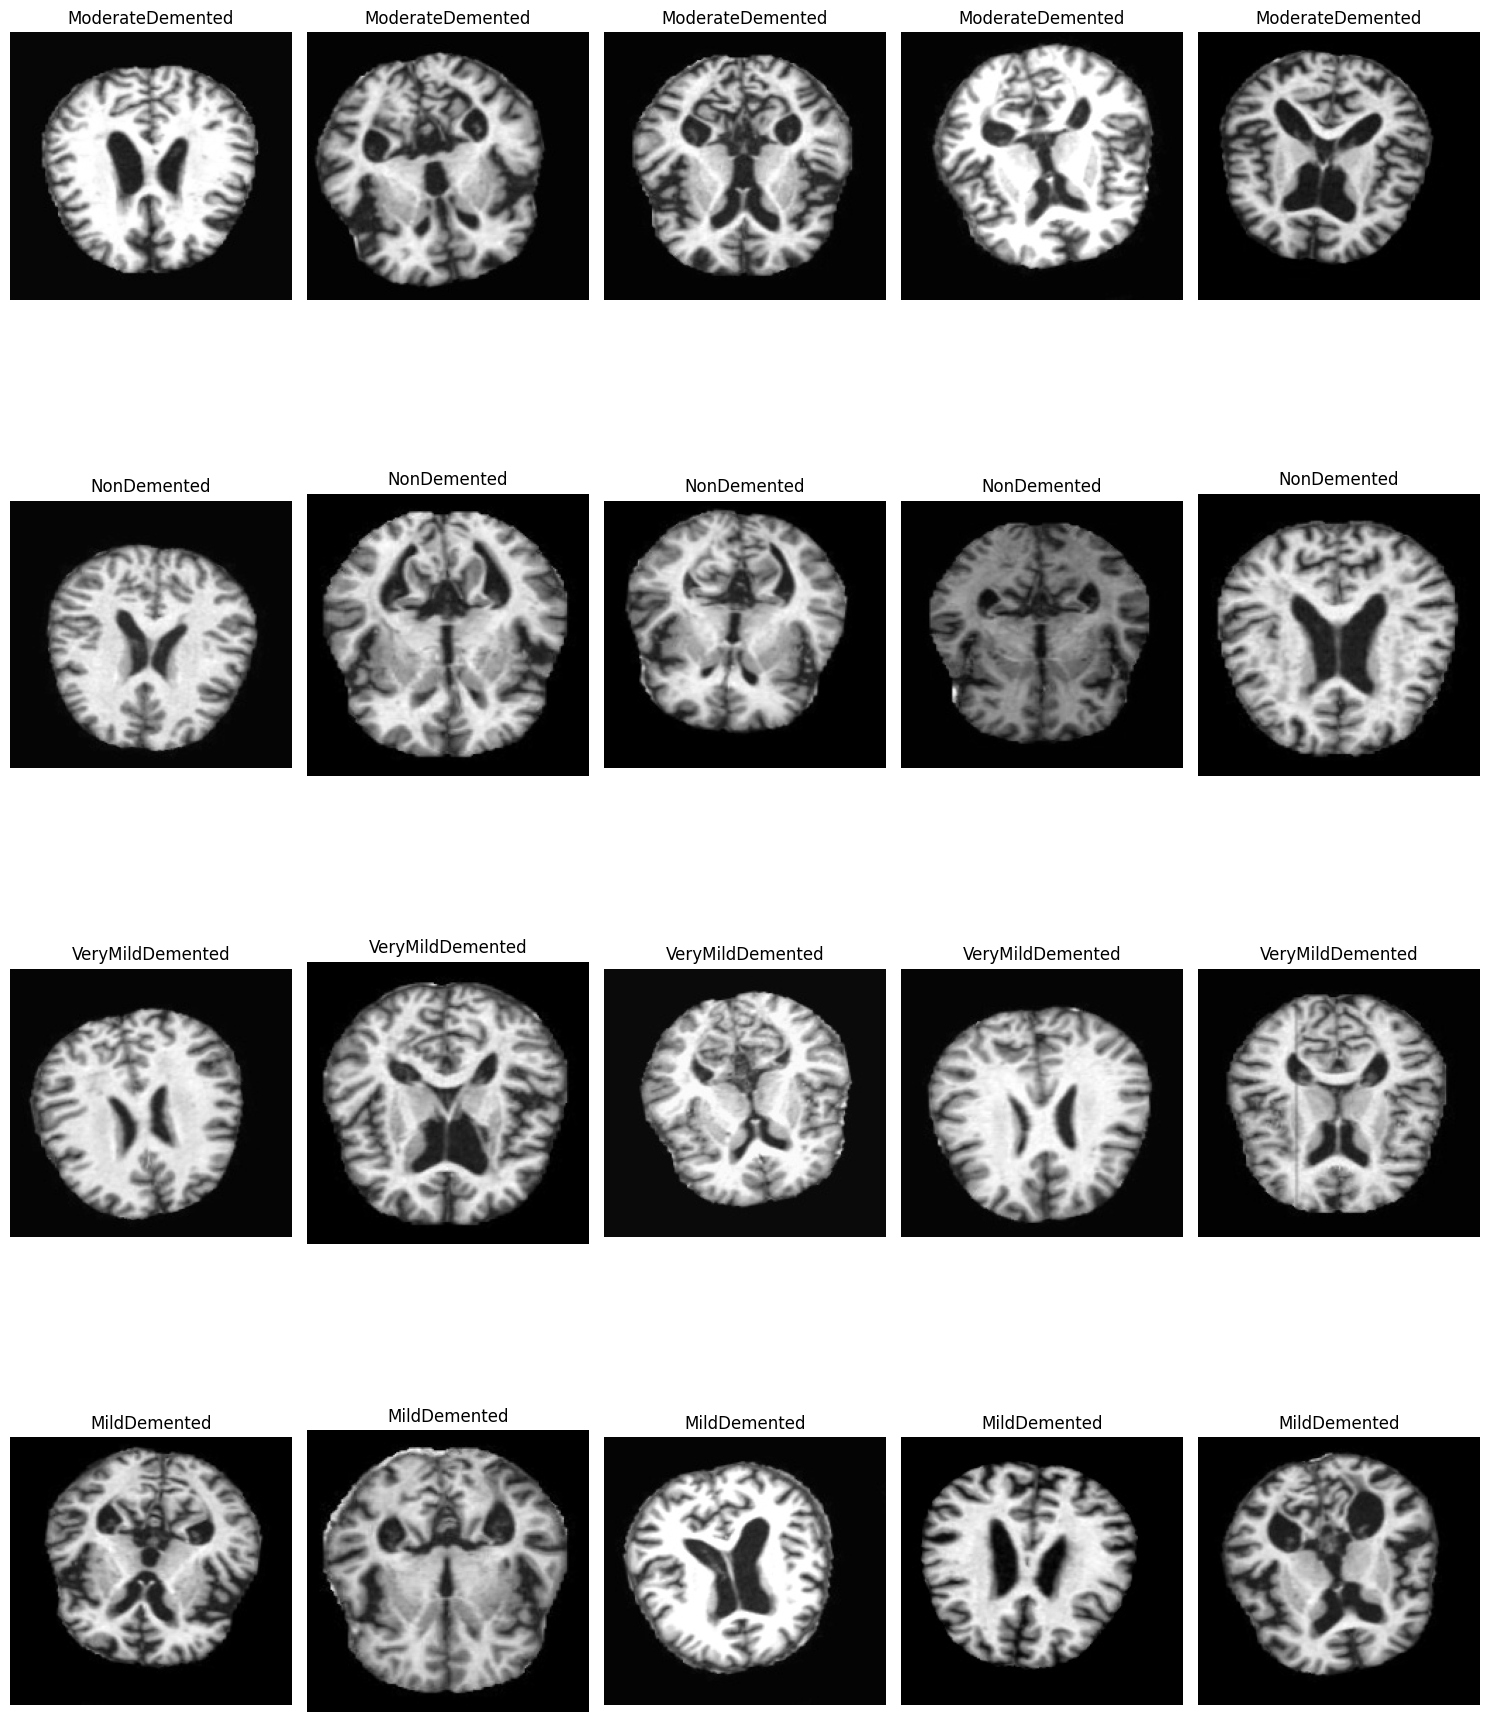

In [8]:
show_random_images("image_path",5, True)

In [ ]:
min_dim = cv2.imread(df["image_path"][0])
min_height, min_width = min_dim.shape[:2]

for image_path in df["image_path"]:
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    min_height = min(min_height, height)
    min_width = min(min_width, width)
print(min_height)
print(min_width)
    

In [ ]:
processed_images = []
    
for img_path in df["image_path"]:
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (180,180))
    
    processed_images.append(img_resized)
    
df["resized_image"] = processed_images


df.head()

In [ ]:
equlaize_hist = []
clahe_hist = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5,5))
    
for img in df["resized_image"]:
    img_equalized = cv2.equalizeHist(img)
    equlaize_hist.append(img_equalized)
    img_clahe = clahe.apply(img)
    clahe_hist.append(img_clahe)
    
df["equlaize_hist"] = equlaize_hist
df["clahe_hist"] = clahe_hist


df.head()

In [ ]:
show_random_images("equlaize_hist",5, True)

In [ ]:
show_random_images("clahe_hist",5, True)

In [ ]:
gblur_images = []
median_images = []
bilat_images = []

    
for img in df["clahe_hist"]:
    
    gblur = cv2.GaussianBlur(img, (5, 5), 0)
    gblur_images.append(gblur)
    
    median = cv2.medianBlur(img, 5)
    median_images.append(median)

    biF = cv2.bilateralFilter(img, 5, 21, 21)
    bilat_images.append(biF)
    
df["gblur_images"] = gblur_images
df["median_images"] = median_images
df["bilat_images"] = bilat_images


df.head()

In [ ]:
show_random_images("gblur_images",5, True)

In [ ]:
show_random_images("median_images",5, True)

In [ ]:
show_random_images("bilat_images",5, True)

# 1- First Method: Using Resnet 152 Model for classification (Accuracy 73%)

In [ ]:
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df = pd.DataFrame(data)

output_csv = "dataset.csv"
df.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")


## Explore Data

In [ ]:
category_counts = df["category"].value_counts()
print(category_counts)

plt.figure(figsize=(12, 5))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%")
plt.title("Category Distribution")
plt.show()

## Apply UnderSampling 

In [ ]:
min_class_size = df['category'].value_counts().min()
undersampled_df = (
    df.groupby('category', group_keys=False)
    .apply(lambda x: x.sample(n=min_class_size, random_state=42))
)

undersampled_csv = "undersampled_dataset.csv"
undersampled_df.to_csv(undersampled_csv, index=False)

print("Dataset undersampled successfully! New dataset saved to:", undersampled_csv)
df = undersampled_df
del undersampled_df
df.head()

In [ ]:
category_counts = df["category"].value_counts()
print(category_counts)

plt.figure(figsize=(12, 5))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%")
plt.title("Category Distribution")
plt.show()

## Image Processing

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(7,7))
processed_images = []
    
for img_path in df["image_path"]:
    img = cv2.imread(img_path)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_resized = cv2.resize(img_gray, (224,224))

    img_clahe = clahe.apply(img_resized)

    biF = cv2.bilateralFilter(img_clahe, 5, 21, 21)

    norm_img = cv2.normalize(biF, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    three_channel_image = cv2.cvtColor(norm_img, cv2.COLOR_GRAY2BGR)
    
    processed_images.append(three_channel_image)
    
df["processed_images"] = processed_images


df.head()

In [ ]:
show_random_images("processed_images",5, True)

## Apply One hot encoding

In [ ]:
df_encoded = pd.get_dummies(df['category'], dtype=int)
df_ohe = pd.concat([df, df_encoded], axis=1)
df = df_ohe.drop(columns=['category', 'image_path'])
del df_ohe, df_encoded
gc.collect()
df.head()

## Model Training and Testing

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
del df
gc.collect()

In [ ]:
def data_generator(df, batch_size):
    num_samples = len(df)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset+batch_size]

            X_batch = np.array(batch_df['processed_images'].tolist())
            Y_batch = batch_df.drop(columns=['processed_images']).values
            
            yield X_batch, Y_batch

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
train_gen = data_generator(train_df, batch_size=32)
val_gen = data_generator(val_df, batch_size=32)
steps_per_epoch = len(train_df) // 32
validation_steps = len(val_df) // 32
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=2000,
    callbacks=[early_stopping]
)

## Confusion Matrix and Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_test = test_df[['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']].values
y_pred = model.predict(np.array(test_df['processed_images'].tolist()))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
report = classification_report(y_true, y_pred_classes, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])
print("Classification Report:")
print(report)

In [ ]:
model.save('Resnet_152_Model.h5')

# 2- Second Method: Using Custom Multi Class Classification Model (Accuracy 89%)

In [ ]:
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df = pd.DataFrame(data)

output_csv = "dataset.csv"
df.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")


## Explore Data

In [ ]:
category_counts = df["category"].value_counts()
print(category_counts)

plt.figure(figsize=(12, 5))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%")
plt.title("Category Distribution")
plt.show()

## Apply UnderSampling 

In [ ]:
min_class_size = df['category'].value_counts().min()
undersampled_df = (
    df.groupby('category', group_keys=False)
    .apply(lambda x: x.sample(n=min_class_size, random_state=42))
)

undersampled_csv = "undersampled_dataset.csv"
undersampled_df.to_csv(undersampled_csv, index=False)

print("Dataset undersampled successfully! New dataset saved to:", undersampled_csv)
df = undersampled_df
del undersampled_df
df.head()

In [ ]:
category_counts = df["category"].value_counts()
print(category_counts)

plt.figure(figsize=(12, 5))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%")
plt.title("Category Distribution")
plt.show()

## Image Processing

In [ ]:
def image_processing(img):
    img = cv2.imread(img)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_resized = cv2.resize(img_gray, (224,224))

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(7,7))
    img_clahe = clahe.apply(img_resized)

    biF = cv2.bilateralFilter(img_clahe, 5, 21, 21)

    norm_img = cv2.normalize(biF, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return norm_img

## Build Model

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.00001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

## Configure Data

In [ ]:
def ohe(df):
    df_encoded = pd.get_dummies(df['category'], dtype=int)
    df_ohe = pd.concat([df, df_encoded], axis=1)
    df = df_ohe.drop(columns=['category', 'image_path'])
    del df_ohe, df_encoded
    gc.collect()
    return df

In [ ]:
def split_df(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
    return train_df, val_df, test_df

In [ ]:
def data_generator(df, batch_size):
    num_samples = len(df)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset+batch_size]

            X_batch = np.array(batch_df['processed_images'].tolist())
            Y_batch = batch_df.drop(columns=['processed_images']).values
            
            yield X_batch, Y_batch

## Model Training and Testing

In [ ]:
def model_train(train_df, val_df):
    train_gen = data_generator(train_df, batch_size=32)
    val_gen = data_generator(val_df, batch_size=32)
    steps_per_epoch = len(train_df) // 32
    validation_steps = len(val_df) // 32
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=50,
        callbacks=[early_stopping]
    )

In [ ]:
def model_test(test_df):
    target_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
    y_test = test_df[target_names].values
    y_pred = model.predict(np.array(test_df['processed_images'].tolist()))
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    report = classification_report(y_true, y_pred_classes, target_names=target_names)
    print(report)

In [ ]:
def process_data_train__test_and_save_model(df, model_name):
    processed_image = []
    for img in df['image_path']:
        processed_image.append(image_processing(img))
    df['processed_images'] = processed_image
    del processed_image
    gc.collect()

    df = ohe(df)

    train_df , val_df , test_df = split_df(df)
    del df
    gc.collect()

    model_train(train_df , val_df)

    model_test(test_df)
    
    model.save(model_name)

In [ ]:
process_data_train__test_and_save_model(df, "Multi_Class_Custom_Model.h5")

# 3- Third Method: One VS Rest Approach Using Four Custom Binary Class Classification Models (Accuracy 81%)

In [ ]:
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df = pd.DataFrame(data)

output_csv = "dataset.csv"
df.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")


## Image Processing

In [ ]:
def image_processing(img):
    img = cv2.imread(img)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_resized = cv2.resize(img_gray, (224,224))

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(7,7))
    img_clahe = clahe.apply(img_resized)

    biF = cv2.bilateralFilter(img_clahe, 5, 21, 21)

    norm_img = cv2.normalize(biF, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return norm_img

In [ ]:
processed_image = []
for img in df['image_path']:
    processed_image.append(image_processing(img))
df['processed_image'] = processed_image
df = df.drop(columns = ['image_path'])

output_csv = "dataset_processed.csv"
df.to_csv(output_csv, index=False)

del processed_image
gc.collect()

## Grouping Classes

In [ ]:
grouped = df.groupby('category')
for category, data in grouped:
    globals()[f"df_{category}"] = data

## Build Model

In [ ]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,1)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

## Configure Data

In [ ]:
def data_generator(df, batch_size):
    num_samples = len(df)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset+batch_size]

            X_batch = np.array(batch_df['processed_image'].tolist())
            Y_batch = np.array(batch_df['category'].tolist())
            
            yield X_batch, Y_batch

In [ ]:
def model_train(train_df, val_df):
    train_gen = data_generator(train_df, batch_size = 4)
    val_gen = data_generator(val_df, batch_size = 4)
    
    steps_per_epoch = len(train_df) // 4
    validation_steps = len(val_df) // 4

    model = create_model()
    history = model.fit(
        train_gen,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_gen,
        validation_steps = validation_steps,
        epochs = 50,
        callbacks = [EarlyStopping (
        monitor = 'val_loss',
        patience = 3,
        restore_best_weights = True
        )]
    )

    return model

In [ ]:
def process_data__train_and_save_model(df, model_name):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    model = model_train(train_df , test_df)
    
    model.save(model_name)

## Model Training and Testing

In [ ]:
train_df, df_NonDemented_test = train_test_split(df_NonDemented, test_size=0.1, random_state=42)
train_df['category'] = 1

sampled_df1 = df_ModerateDemented.sample(n = len(train_df)  // 3, random_state=42)
sampled_df2 = df_MildDemented.sample(n = len(train_df)  // 3, random_state=42)
sampled_df3 = df_VeryMildDemented.sample(n = len(train_df)  // 3, random_state=42)

sampled_df = pd.concat([sampled_df1, sampled_df2, sampled_df3], ignore_index=True)
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_NonDemented.h5")

In [ ]:
train_df, df_ModerateDemented_test = train_test_split(df_ModerateDemented, test_size=0.1, random_state=42)
train_df['category'] = 1

sampled_df1 = df_NonDemented.sample(n = len(train_df) // 3, random_state=42)
sampled_df2 = df_MildDemented.sample(n = len(train_df) // 3, random_state=42)
sampled_df3 = df_VeryMildDemented.sample(n = len(train_df) // 3, random_state=42)

sampled_df = pd.concat([sampled_df1, sampled_df2, sampled_df3], ignore_index=True)
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_ModerateDemented.h5")

In [ ]:
train_df, df_MildDemented_test = train_test_split(df_MildDemented, test_size=0.1, random_state=42)
train_df['category'] = 1

sampled_df1 = df_NonDemented.sample(n = len(train_df) // 3, random_state=42)
sampled_df2 = df_ModerateDemented.sample(n = len(train_df) // 3, random_state=42)
sampled_df3 = df_VeryMildDemented.sample(n = len(train_df) // 3, random_state=42)

sampled_df = pd.concat([sampled_df1, sampled_df2, sampled_df3], ignore_index=True)
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_MildDemented.h5")

In [ ]:
train_df, df_VeryMildDemented_test = train_test_split(df_VeryMildDemented, test_size=0.1, random_state=42)
train_df['category'] = 1

sampled_df1 = df_NonDemented.sample(n = len(train_df) // 3, random_state=42)
sampled_df2 = df_ModerateDemented.sample(n = len(train_df) // 3, random_state=42)
sampled_df3 = df_MildDemented.sample(n = len(train_df) // 3, random_state=42)

sampled_df = pd.concat([sampled_df1, sampled_df2, sampled_df3], ignore_index=True)
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_VeryMildDemented.h5")

In [ ]:
NonDemented_model = load_model('/kaggle/working/model_NonDemented.h5')
ModerateDemented_model = load_model('/kaggle/working/model_ModerateDemented.h5')
MildDemented_model = load_model('/kaggle/working/model_MildDemented.h5')
VeryMildDemented_model = load_model('/kaggle/working/model_VeryMildDemented.h5')

target_names=["NonDemented", "ModerateDemented", "MildDemented", "VeryMildDemented", "NotSure"]

df = pd.concat([df_NonDemented_test, df_ModerateDemented_test, df_MildDemented_test, df_VeryMildDemented_test], ignore_index=True)

Y_Predict = []
Y_True = []

for img, category in zip(df['processed_image'], df['category']):
    if category == "NonDemented":
        Y_True.append(0)
    elif category == "ModerateDemented":
        Y_True.append(1)
    elif category == "MildDemented":
        Y_True.append(2)
    elif category == "VeryMildDemented":
        Y_True.append(3)
        
    predicted_label = 4

    if NonDemented_model.predict(np.expand_dims(img, axis=0), verbose=0) >= 0.55:
        predicted_label = 0
    elif ModerateDemented_model.predict(np.expand_dims(img, axis=0), verbose=0) >= 0.75:
        predicted_label = 1
    elif MildDemented_model.predict(np.expand_dims(img, axis=0), verbose=0) >= 0.55:
        predicted_label = 2
    elif VeryMildDemented_model.predict(np.expand_dims(img, axis=0), verbose=0) >= 0.45:
        predicted_label = 3

    Y_Predict.append(predicted_label)
    
Y_True = np.array(Y_True)
Y_Predict = np.array(Y_Predict)

cm = confusion_matrix(Y_True, Y_Predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = target_names, yticklabels = target_names)
plt.show()

report = classification_report(Y_True, Y_Predict, target_names = target_names)
print(report)

# 4- Fourth Method: One VS One Approach Using Six Custom Binary Class Classification Models (Accuracy 96%)

In [ ]:
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df = pd.DataFrame(data)

output_csv = "dataset.csv"
df.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")


## Image Processing

In [ ]:
def image_processing(img):
    img = cv2.imread(img)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_resized = cv2.resize(img_gray, (224,224))

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(7,7))
    img_clahe = clahe.apply(img_resized)

    norm_img = cv2.normalize(img_clahe, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return norm_img

In [ ]:
processed_image = []
for img in df['image_path']:
    processed_image.append(image_processing(img))
df['processed_image'] = processed_image
df = df.drop(columns = ['image_path'])

output_csv = "dataset_processed.csv"
df.to_csv(output_csv, index=False)

del processed_image
gc.collect()

## Grouping Data

In [ ]:
grouped = df.groupby('category')
for category, data in grouped:
    globals()[f"df_{category}"] = data

## Build Models

In [ ]:
def create_model(add_more_layers):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,1)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    if add_more_layers:
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def create_Deep_model(add_more_layers):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    if add_more_layers:
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    if add_more_layers:
        model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer = Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

## Configure Data

In [ ]:
def data_generator(df, batch_size):
    num_samples = len(df)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset+batch_size]

            X_batch = np.array(batch_df['processed_image'].tolist())
            Y_batch = np.array(batch_df['category'].tolist())
            
            yield X_batch, Y_batch

In [ ]:
def model_train(train_df, val_df, add_more_layers, patience, use_deep_model):
    train_gen = data_generator(train_df, batch_size = 4)
    val_gen = data_generator(val_df, batch_size = 4)
    
    steps_per_epoch = len(train_df) // 4
    validation_steps = len(val_df) // 4

    model = -1

    if use_deep_model:
        model = create_Deep_model(add_more_layers)
    else:
        model = create_model(add_more_layers)
        
    model_history = model.fit(
        train_gen,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_gen,
        validation_steps = validation_steps,
        epochs = 50,
        callbacks = [EarlyStopping (
        monitor = 'val_loss',
        patience = patience,
        restore_best_weights = True
        )]
    )

    return model, model_history

In [ ]:
def plot_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_loss, label='Training Loss', color='blue')
    ax1.plot(val_loss, label='Validation Loss', color='orange')
    ax1.set_title('Loss Curve')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_acc, label='Training Accuracy', color='green')
    ax2.plot(val_acc, label='Validation Accuracy', color='red')
    ax2.set_title('Accuracy Curve')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def process_data__train_and_save_model(df, model_name, add_more_layers, patience, use_deep_model):
    df = df.sample(frac=1).reset_index(drop=True)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    model, model_history = model_train(train_df , test_df, add_more_layers, patience, use_deep_model)

    plot_curves(model_history)
    
    model.save(model_name)

## Models Training

In [ ]:
train_df, df_NonDemented_test = train_test_split(df_NonDemented, test_size=0.2, random_state=42)
train_df['category'] = 1

In [ ]:
sampled_df = df_VeryMildDemented.sample(n = len(train_df), random_state=42)
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_NonVSVeryMild.h5", True, 5, True)

In [ ]:
sampled_df = df_MildDemented.sample(n = len(train_df), random_state=42)
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_NonVSMild.h5", True, 5, True)

In [ ]:
sampled_df = df_ModerateDemented.copy()
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_NonVSModerate.h5", False, 2, False)

In [ ]:
train_df, df_VeryMildDemented_test = train_test_split(df_VeryMildDemented, test_size=0.2, random_state=42)
train_df['category'] = 1

In [ ]:
sampled_df = df_MildDemented.sample(n = len(train_df), random_state=42)
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_VeryMildVSMild.h5", True, 5, True)

In [ ]:
sampled_df = df_ModerateDemented.copy()
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_VeryMildVSModerate.h5", False, 2, False)

In [ ]:
train_df, df_MildDemented_test = train_test_split(df_MildDemented, test_size=0.2, random_state=42)
train_df['category'] = 1

In [ ]:
sampled_df = df_ModerateDemented.copy()
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_MildVSModerate.h5", True, 2, False)

In [ ]:
train_df, df_ModerateDemented_test = train_test_split(df_ModerateDemented, test_size=0.2, random_state=42)

## Models Final Testing

In [ ]:
df = pd.concat([df_NonDemented_test, df_VeryMildDemented_test, df_MildDemented_test, df_ModerateDemented_test], ignore_index=True)

df = df.sample(n = len(df) //10).reset_index(drop=True)

In [ ]:
Y_True = []

for category in df['category']:
    if category == "NonDemented":
        Y_True.append(0)
    elif category == "VeryMildDemented":
        Y_True.append(1)
    elif category == "MildDemented":
        Y_True.append(2)
    elif category == "ModerateDemented":
        Y_True.append(3)

In [ ]:
NonVSVeryMild_model = load_model('model_NonVSVeryMild.h5')
NonVSMild_model = load_model('model_NonVSMild.h5')
NonVSModerate_model = load_model('model_NonVSModerate.h5')

VeryMildVSMild_model = load_model('model_VeryMildVSMild.h5')
VeryMildVSModerate_model = load_model('model_VeryMildVSModerate.h5')

MildVSModerate_model = load_model('model_MildVSModerate.h5')

confidence = {
    'NonVSVeryMild': 0.9264,
    'NonVSMild': 0.9684,
    'NonVSModerate': 0.9947,
    'VeryMildVSMild': 0.9449,
    'VeryMildVSModerate': 0.9952,
    'MildVSModerate': 0.9820
}

In [ ]:
def predict_with_thresholds(img):
    img = np.expand_dims(img, axis=0)

    NonVSVeryMild_Predict = float(NonVSVeryMild_model.predict(img, verbose=0))
    NonVSMild_Predict = float(NonVSMild_model.predict(img, verbose=0))
    NonVSModerate_Predict = float(NonVSModerate_model.predict(img, verbose=0))

    VeryMildVSMild_Predict = float(VeryMildVSMild_model.predict(img, verbose=0))
    VeryMildVSModerate_Predict = float(VeryMildVSModerate_model.predict(img, verbose=0))

    MildVSModerate_Predict = float(MildVSModerate_model.predict(img, verbose=0))

    predictionProbabilities = [0, 0, 0, 0]
    predictionProbabilities[0] = ((NonVSVeryMild_Predict * confidence['NonVSVeryMild']) + (NonVSMild_Predict * confidence['NonVSMild']) + (NonVSModerate_Predict * confidence['NonVSModerate'])) / 3
    predictionProbabilities[1] = (((1 - NonVSVeryMild_Predict) * confidence['NonVSVeryMild']) + (VeryMildVSMild_Predict * confidence['VeryMildVSMild']) + (VeryMildVSModerate_Predict * confidence['VeryMildVSModerate'])) / 3
    predictionProbabilities[2] = (((1 - NonVSMild_Predict) * confidence['NonVSMild']) + ((1 - VeryMildVSMild_Predict) * confidence['VeryMildVSMild']) + (MildVSModerate_Predict * confidence['MildVSModerate'])) / 3
    predictionProbabilities[3] = (((1 - NonVSModerate_Predict) * confidence['NonVSModerate']) + ((1 - VeryMildVSModerate_Predict) * confidence['VeryMildVSModerate']) + ((1 - MildVSModerate_Predict) * confidence['MildVSModerate'])) / 3

    maxProb = np.argmax(predictionProbabilities)
    if predictionProbabilities[maxProb] >= 0.8:
        return maxProb
    else:
        return 4

In [ ]:
Y_Predict = []
for img in df['processed_image']:
    Y_Predict.append(predict_with_thresholds(img))

Y_True = np.array(Y_True)
Y_Predict = np.array(Y_Predict)

In [ ]:
target_names=["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented", "Unsure"]

In [ ]:
cm = confusion_matrix(Y_True, Y_Predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = target_names, yticklabels = target_names)
plt.show()

report = classification_report(Y_True, Y_Predict, target_names = target_names)
print(report)